# Evaluation

This Notebook contains the evaluation of all used machine learning models during this project. \
Evaluation and Validation will be performed on the test and validation data 

In [1]:
# Imports 
import sys
sys.path.append("..")
import pandas as pd 
import matplotlib.pyplot as plt
from model.helpers import *
from model.predict import *
from collections import defaultdict
from sklearn.metrics import (
    roc_curve, auc, 
    precision_score,
    roc_auc_score,
    recall_score,
    brier_score_loss, 
    f1_score, 
    confusion_matrix)

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

In [2]:
#load data 
TRAIN = {}
TEST = {}
VALIDATION = {}

path = "../../data/interim/raw"
train = "train_"
test = "test_"
validation = "validation_"
#  list of scenarios
scenarios = [
        'CVE-2012-2122',
        'CVE-2014-0160',
        'CVE-2017-7529',
        'CVE-2017-12635_6',
        'CVE-2018-3760',
        'CVE-2019-5418',
        'CVE-2020-9484',
        'CVE-2020-13942',
        'CVE-2020-23839',
        'CWE-89-SQL-injection'
]

for i in range(0,len(scenarios)):
    TRAIN[scenarios[i]]= pd.read_pickle(path + "/" + train + scenarios[i] + ".pkl")
    TEST[scenarios[i]] = pd.read_pickle(path + "/" + test + scenarios[i] + ".pkl")
    VALIDATION[scenarios[i]] = pd.read_pickle(path + "/" + validation + scenarios[i] + ".pkl")
            

In [3]:
# load each model for each Scenario
model_type ='KMEANS'
kmeans_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    kmeans_[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])


model_type ='IsolationForest'
IsoForests = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    IsoForests[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])

model_type ='ExtendedIsolationForest'
E_IsoForests = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    E_IsoForests[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])


model_type ='LocalOutlierFactor'
lof_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    lof_[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])


model_type ='DBSCAN'
dbscan_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    dbscan_[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])


model_type ='SVM'
svm_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    svm_[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])

In [8]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers
    # encode to fit Isolation Forest predicitons 
    y_true[scenarios[i]] = y_true[scenarios[i]].mask(y_true[scenarios[i]]==1, -1) # now # remember -1 outliers
    y_true[scenarios[i]]  = y_true[scenarios[i]].mask(y_true[scenarios[i]]==0,  1) # 1 = inliners
 

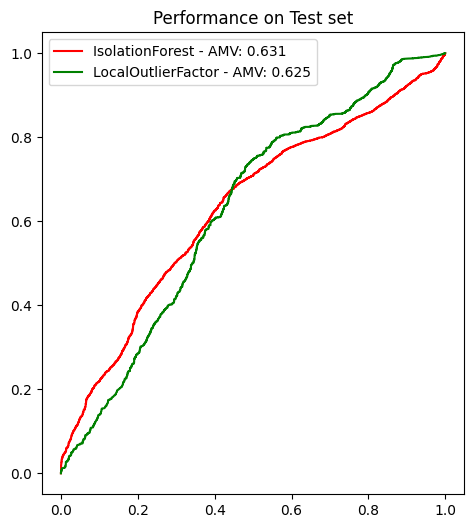

In [14]:
# Scenario CVE-2012-2122  
scenario = "CVE-2014-0160" 
# prepare test data 
X_test = TEST[scenario]
X_test = select_columns_for_modelling(X_test)

algorithms = [ IsoForests[scenario], lof_[scenario] ] #kmeans_[scenario] # E_IsoForests[scenario], 'DBSCAN', 'SVM']
name = ['IsolationForest',  'LocalOutlierFactor'] #'DBSCAN', 'SVM']#'KMEANS', #'ExtendedIsolationForest'
colors = ['red', 'green', 'blue', 'fuchsia', 'darkviolet']

plt.figure(figsize=(12, 6))
for a, algo in enumerate(algorithms):
   algo_test = algo.decision_function(X_test)
   # algo_validation = algo.decision_function(X_validation)

   # as only one class available auc does not work -> Brier Score!
   #fpr_train_, tpr_train_, _ = roc_curve(y_true_train, -algo_train)
   #algo_auc_train = auc(fpr_train_, tpr_train_)
    
   fpr_test_, tpr_test_, _ = roc_curve(y_true[scenario], algo_test, pos_label=1) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
   algo_auc_test = auc(fpr_test_, tpr_test_)

   # as only one class available auc does not work -> Brier Score!
   #fpr_validation_, tpr_validation_, _ = roc_curve(y_true_validation, -algo_validation)
   #algo_auc_validation = auc(fpr_validation_, tpr_validation_)

   #plt.subplot(1, 2, 1)
   #plt.title('Performance on Training set')
   #plt.plot(fpr_train_, tpr_train_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_train))
    
   plt.subplot(1, 2, 2)
   plt.title('Performance on Test set')
   plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AMV: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
    
   #plt.subplot(1, 2, 1)
   #plt.title('Performance on Validation set')
   #plt.plot(fpr_validation_, tpr_validation_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_validation))
    


plt.subplot(1, 2, 2)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.show()

In [7]:
algorithms

[KMeans(n_clusters=2),
 IsolationForest(n_jobs=-1, random_state=42),
 LocalOutlierFactor(contamination=0.1532595823344213, n_jobs=-1, novelty=True),
 DBSCAN(),
 <module 'sklearn.svm' from '/Users/janavihs/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/svm/__init__.py'>]